In [3]:
from requests import get, post
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import sympy as sp
from matplotlib import pyplot as plt

# Carga de Dados
**Origem dos dados**

[Binance](https://www.binance.com)

[Documentação da API](https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md#klinecandlestick-data)

In [4]:
# Endpoints
url = 'https://api3.binance.com'
klines = url + '/api/v3/klines'
info = url + '/api/v3/exchangeInfo'

In [11]:
# Colunas
col = [
    'Open time','Open','High','Low','Close','Volume','Close time',
    'Quote asset volume','Number of trades','Taker buy base asset volume',
    'Taker buy quote asset volume','Ignore'
]

# Parametros
assets = ['btc', 'nano', 'bnb', 'waves', 'eos']
interval = '1d'
limit = 365
params = {}
def create_params(asset) -> dict:
    params[asset] = {
        "symbol": f"{asset.upper()}USDT",
        "interval": interval,
        "limit": limit
    }
    return params

for i in assets:
    create_params(i)

In [6]:
params

{'btc': {'symbol': 'BTCUSDT', 'interval': '1d', 'limit': 365},
 'nano': {'symbol': 'NANOUSDT', 'interval': '1d', 'limit': 365},
 'bnb': {'symbol': 'BNBUSDT', 'interval': '1d', 'limit': 365},
 'waves': {'symbol': 'WAVESUSDT', 'interval': '1d', 'limit': 365},
 'eos': {'symbol': 'EOSUSDT', 'interval': '1d', 'limit': 365}}

## Obtendo os preços dos ativos

In [7]:
def clean(x):    
    # Obtendo dados
    asset = get(klines, params=params[x]).json()

    # Limpando - > deixando apenas as colunas: (close, time_close)
    asset = np.array(asset, dtype=float)[..., 4]
    
    return asset

- **map** aplica a função **clean** para cada **key** do dict **params**
- **np.array** transforma o map desepacotado <strong>[*map]</strong> em um array numpy (matriz)
- **pd.DataFrame** compila a transposta **array.T** da matriz em um dataframe pandas
- **to_csv** salvo no disco o dataframe limpo

In [52]:
df = pd.DataFrame(np.array([*map(clean, params.keys())]).T, columns=params.keys())
df.to_csv(r'./data_criptoMarkets.csv',index=False)

## Visualizando Dados

In [57]:
df = pd.read_csv('data_criptoMarkets.csv')
df

,btc,nano,bnb,waves,eos
0,6236.65,0.4658,12.1888,0.8144,2.1996
1,5881.42,0.4353,11.3008,0.7710,2.1133
2,6394.38,0.4600,12.1365,0.8262,2.2269
3,6410.44,0.4694,12.5451,0.9900,2.2086
4,6642.92,0.4927,12.7200,0.9698,2.2549
...,...,...,...,...,...
360,54340.89,4.8537,255.4646,11.1934,4.0899
361,52303.65,4.5016,248.5236,10.8360,3.6938
362,51293.78,4.1405,233.9466,10.4376,3.6745
363,55025.59,4.4502,255.2105,12.2797,4.1849


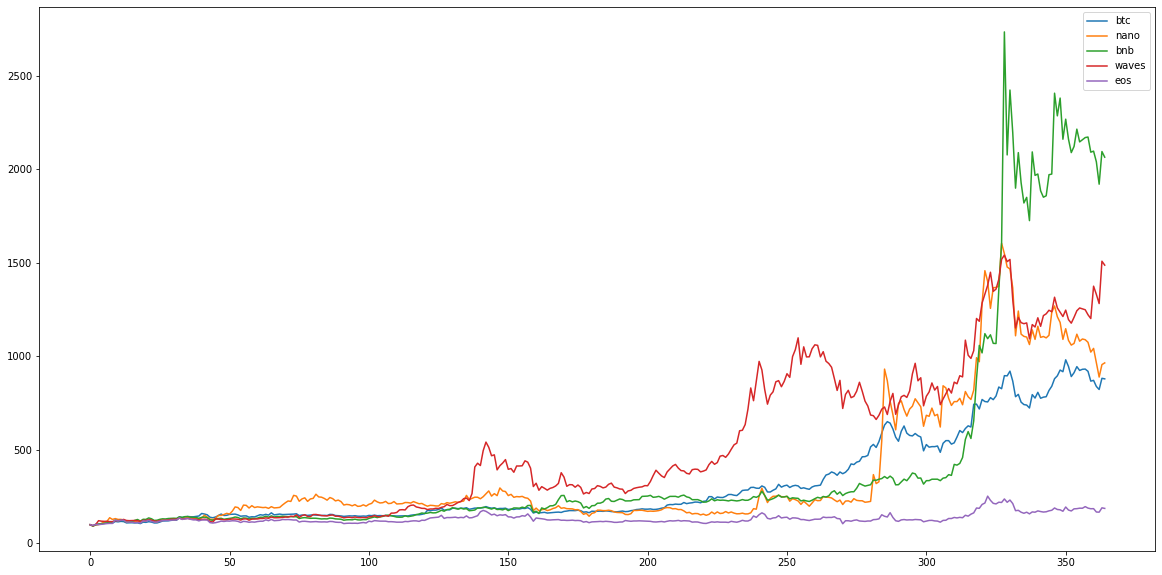

In [58]:
# Normaliza os dados na base 100
(df / df.iloc[0] * 100).plot(figsize=(20,10))
plt.show()

# Calculando Taxa de Retorno Simples, Logarítmicos e Volatilidade

**Retorno Simples:**
$$
r = \frac{P_i - P_f}{P_i} = \frac{P_f}{P_i} - 1
$$

**Retornos Logarítmicos**

$$
r = log(\frac{P_t}{P_{t-1}})
$$

In [16]:
def simple_return(asset):
    new_asset = (df[asset] / df[asset].shift(1)) - 1
    return new_asset

def log_return(asset):
    new_asset = (df[asset] / df[asset].shiftt(1)) - 1
    return new_asset

## Gráfico dos Retorno Simples Diários
- **map** aplica a função **simple_return** para cada **column** do dataframe **df**
- **pd.DataFrame** compila a transposta **array.T** do map desepacotado <strong>[*map]</strong> em um dataframe **df**
- **iloc** fatia o **df** retirando a primeira linha **[1:,:]**

In [17]:
assets_returns = pd.DataFrame([*map(simple_return, df)]).T.iloc[1:,:]
assets_returns

,btc,nano,bnb,waves,eos
1,-0.019257,-0.011880,-0.011884,-0.051921,0.003101
2,-0.056958,-0.065479,-0.072854,-0.053291,-0.039234
3,0.087217,0.056742,0.073951,0.071595,0.053755
4,0.002512,0.020435,0.033667,0.198257,-0.008218
5,0.036266,0.049638,0.013942,-0.020404,0.020964
...,...,...,...,...,...
360,-0.056987,-0.048665,-0.037233,-0.016543,-0.018273
361,0.004764,0.019235,0.002618,0.143888,0.002992
362,-0.037490,-0.072543,-0.027170,-0.031930,-0.096848
363,-0.019308,-0.080216,-0.058654,-0.036766,-0.005225


In [22]:
# Normalização entre 1 e -1
def norm(df):
    normalize = MaxAbsScaler().fit_transform(df)
    return normalize

In [61]:
# calculando desvio padrão dos retornos nomalizados
std = norm(assets_returns).std() *2
x_hat = norm(assets_returns).mean()
print(f'{std*100:.2f}%')
print(f'{x_hat*100:.2f}%')

32.94%
1.89%


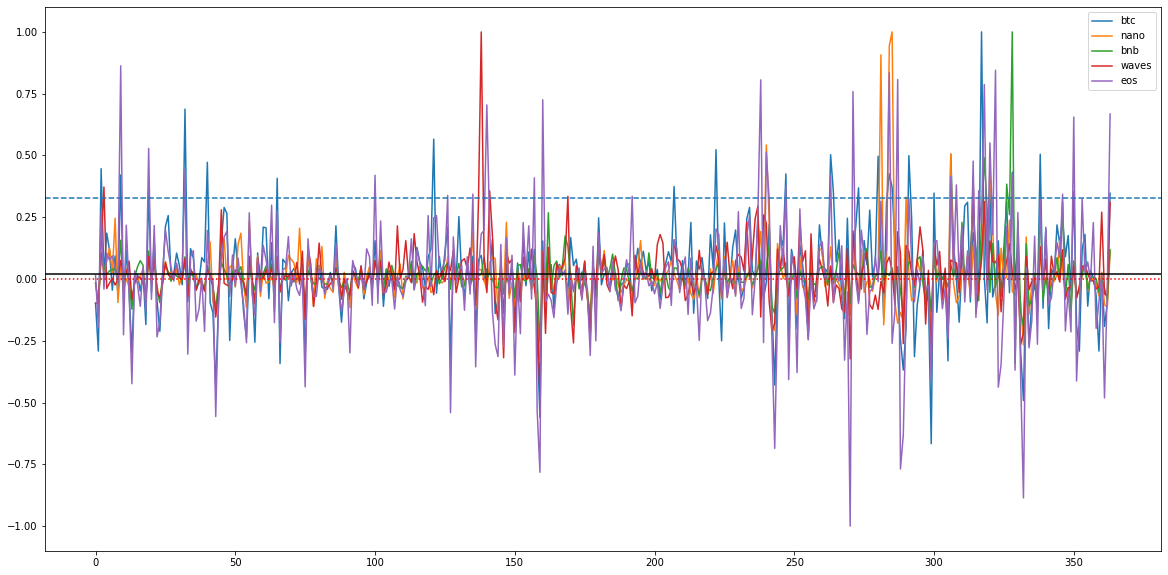

In [64]:
# Retornos diarios
pd.DataFrame(norm(assets_returns), columns=assets).plot(figsize=(20,10))
plt.axhline(y=std, linestyle='--')
plt.axhline(y=0, linestyle=':', color='#f00')
plt.axhline(y=x_hat, linestyle='-', color='#000')
plt.show()

### Calculando o Retorno Simples Diário e Anual

In [24]:
def mean_returns(asset):
    # media diaria
    x = assets_returns[asset].mean() * 100
    
    # media anual
    y = assets_returns[asset].mean() * 365 * 100
    
    # variacao diaria 
    z = assets_returns[asset].std() * 100

    # desvio padrao anual
    w = assets_returns[asset].std() * 365 ** 0.5 * 100
    return [x,y,z,w]

- **map** aplica a função **mean_returns** para cada *column* do dataframe **df**
- **pd.DataFrame** compila o map desempacotado <strong>[*map]</strong> em um dataframe **df**

In [25]:
col = ['Retorno Médio Diário', 'Retorno Médio Anual', 'Desvio Padrão Diário', 'Desvio Padrão Anual']
returns = pd.DataFrame(np.array([*map(mean_returns, assets_returns)]), index=assets_returns.columns,columns=col)
returns.style.format('{:.2f}%')

,Retorno Médio Diário,Retorno Médio Anual,Desvio Padrão Diário,Desvio Padrão Anual
btc,0.66%,240.13%,3.63%,69.30%
nano,0.96%,349.51%,8.97%,171.39%
bnb,1.03%,375.88%,6.68%,127.55%
waves,0.93%,339.47%,6.47%,123.61%
eos,0.30%,109.39%,4.97%,95.02%


## Calculando Taxa de Retorno de um Portifólio

**Retorno do Portifólio**

```
O retorno do portifólio é dado pelo somatório do produto
dos retornos(sigma) pelo seu respectivo peso(w) na carteira 
```

$$
r =\begin{bmatrix}
    \sigma_1 \\
    \vdots \\
    \sigma_n
\end{bmatrix} 
\times \begin{bmatrix} w_1 \dots w_n \end{bmatrix}
$$

$$
r = \sum_{i=1}^{n} \sigma_i \times w_i
$$




In [89]:
# retornos anuais
annual_return = assets_returns.mean() * 365
annual_return

btc      2.401347
nano     3.495095
bnb      3.758798
waves    3.394653
eos      1.093852
dtype: float64

### Simulação de Portifólios

In [67]:
# pesos de cada ativo na carteira
weights_A = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Somatório do produto vetorial
portifolio_return_A = np.dot(annual_return, weights_A) * 100
print("Portifólio A")
print(str(round(portifolio_return_A, 2)) + '%')

Portifólio A
193.75%


In [68]:
# pesos de cada ativo na carteira
weights_B = np.array([0.2, 0.2, 0.2, 0., 0.4])

# Somatório do produto vetorial
portifolio_return_B = np.dot(annual_return, weights_B) * 100
print("Portifólio B")
print(str(round(portifolio_return_B, 2)) + '%')

Portifólio B
162.23%


In [69]:
# pesos de cada ativo na carteira
weights_C = np.array([0.3, 0.1, 0.1, 0.3, 0.2])

# Somatório do produto vetorial
portifolio_return_C = np.dot(annual_return, weights_C) * 100
print("Portifólio C")
print(str(round(portifolio_return_C, 2)) + '%')

Portifólio C
183.76%


# Risco e Volatilidade 

**Variância**

```
Mede a distância entre os valores e a média.
var(x) = média dos  quadrados - quadrado da média
```
$$
var(x) = \frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})^2
$$

$$
= \frac{1}{n}\sum_{i=1}^{n}x_i² - \bar{x}²
$$

**Desvio Padrão**
```
Mede a variação média
dp(x) = raiz quadrada da variância
```
$$
\sigma(x) = \sqrt{var(x)}
$$

## Calculando Volatilidade dos Ativos

In [81]:
def stats(asset):
    # variancia diaria
    var_d = assets_returns[asset].var() * 100
    
    # desvio padrao diario
    std_d = assets_returns[asset].std() * 100
    
    # variancia anual
    var_y = assets_returns[asset].var() * 100 * 365

    # variancia anual
    std_y = assets_returns[asset].std() * 365 ** 0.5 * 100

    return [var_d, var_y, std_d, std_y]

In [83]:
col = ['Variância Média Diária', 'Variância Média Anual', 'Desvio Padrão Diário', 'Desvio padrão Anual']
assets_var = pd.DataFrame(np.array([*map(stats, assets_returns)]), index=assets_returns.columns, columns=col)
assets_var.style.format('{:.5f}%')

,Variância Média Diária,Variância Média Anual,Desvio Padrão Diário,Desvio padrão Anual
btc,0.13158%,48.02681%,3.62740%,69.30138%
nano,0.80475%,293.73394%,8.97079%,171.38668%
bnb,0.44569%,162.67788%,6.67602%,127.54524%
waves,0.41864%,152.80497%,6.47027%,123.61431%
eos,0.24735%,90.28178%,4.97340%,95.01673%


## Covariancia e Correlação

**Covariância**

```
Mede o grau de interdependência entre as variáveis
Cov(x,y) = média dos produtos - produto das médias
cov(x,y) >  0: x e y se movem na mesma direção
cov(x,y) <  0: x e y se movem em direções contrárias
cov(x,y) == 0: x e y são independentes
```
$$
cov(x, y) = \frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})\cdot(y_i - \bar{y})
$$
$$
= \frac{1}{n}\sum_{i=1}^{n}x_i^2-\bar{x}^2
$$

**Coeficiente de Correlação**
```
Ajusta a cov(x,y) para um intervalo de [-1;1]
Corr(x,y) = {
        média dos produtos - produto das médias
        roduto das raiz quadrada da variância de x por y
}        
corr(x,y) = +ou- 1: o movimento de uma variável explica completamente o movimento da outra
corr(x,y) =  1: correlação positiva perfeita entre as duas variáveis.
corr(x,y) = -1: correlação negativa perfeita entre as duas variáveis.
corr(x,y) =  0: correlação nula
```

$$
corr(x,y) = \frac{cov(x,y)}{\sigma(x)\cdot \sigma(y)}
$$


**Matriz de Covariância**
$$
\begin{bmatrix}
var(x) && cov(x,y) \\
cov(x,y) && var(y)
\end{bmatrix}
$$

## Calculando Covariancia e Correlações

In [84]:
# covariancia anual
cov = assets_returns.cov() * 365
cov.style.background_gradient(cmap='coolwarm')

,btc,nano,bnb,waves,eos
btc,0.480268,0.529308,0.435411,0.333880,0.400069
nano,0.529308,2.937339,0.682925,0.732575,0.774081
bnb,0.435411,0.682925,1.626779,0.625572,0.622417
waves,0.333880,0.732575,0.625572,1.528050,0.536602
eos,0.400069,0.774081,0.622417,0.536602,0.902818


In [85]:
# correlação total
corr = assets_returns.corr()
corr.style.background_gradient(cmap='coolwarm')

,btc,nano,bnb,waves,eos
btc,1.000000,0.445645,0.492599,0.389744,0.607565
nano,0.445645,1.000000,0.312415,0.345785,0.475345
bnb,0.492599,0.312415,1.000000,0.396775,0.513591
waves,0.389744,0.345785,0.396775,1.000000,0.456860
eos,0.607565,0.475345,0.513591,0.456860,1.000000


# Risco de um Portifólio Simples

**A Variação(Risco) depende de:**
- *Desvio Padrão das ações*
- *Correlação entre as ações*

**Variação do Portifólio**
$$
\sigma1
$$
**Volatilidade do Portifólio**
$$
\sigma2
$$

In [86]:
# Peso das Ações
weights = np.full(5, 1/5)
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [87]:
# Variação do Portifólio
pfolio_var = np.dot(weights.T, np.dot(assets_returns.cov() *250, weights))
print(f'{pfolio_var*100:.2f}%')

51.56%


In [88]:
# Volatilidade do Portifólio
pfolio_vol = np.dot(weights.T, np.dot(assets_returns.cov() *250, weights)) ** 0.5
print(f'{pfolio_vol*100:.2f}%')

71.81%
